# Using KBinsDiscretizer to creat Binned Categories

In this notebook we will use the student performance dataset. This notebook will demonstrate how to apply SciKit-Learns KBinsDiscretizer to create binned categories for data and study outliers using category bins

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer

In [2]:
student_marks = pd.read_csv('Datasets/student_performance.csv')

student_marks.sample(10)

,Hours Studied,Score Obtained,Outliers
120,991,99.898515,False
89,822,13.000000,True
39,296,19.030956,False
24,172,5.040238,False
52,420,50.999867,False
80,766,98.510907,False
73,653,94.459048,False
35,274,15.290449,False
81,767,98.528408,False
8,83,1.791570,False


This dataset has the amount of hours that the student studied and the score a student obtained, logically there should be some correlation between amount of hours studied and the score. If you study more hours the more likely you are to get a higher score. However, we do see some outliers in our data, this could be for students who perhaps did not fall under our logical assumption for whatever reason (studied a lot but didnt do well or studied very little and did well)

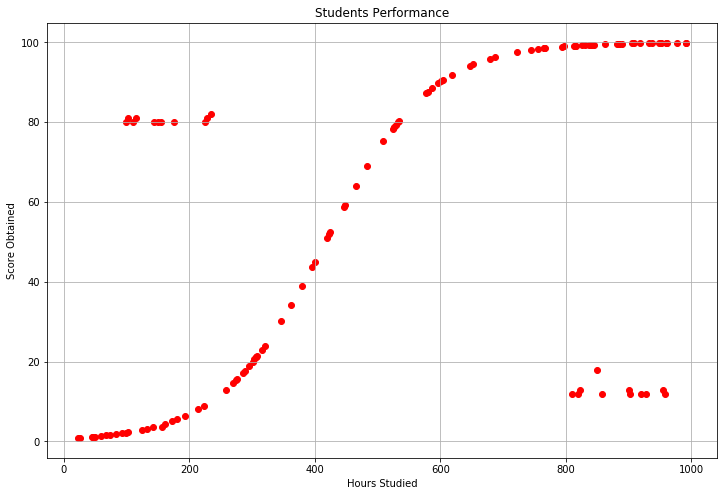

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))

plt.scatter(student_marks['Hours Studied'], student_marks['Score Obtained'], color='red')

ax.set(xlabel='Hours Studied', ylabel='Score Obtained',
       title='Students Performance')
ax.grid()

plt.show()

The scatterplot shows us that most students in our dataset fall under our Scurve, the outliers do not. We can use the KBinzDiscretizer to study outliers in our student data and the different cases within our data.

KBinsDiscretizer has three parameters:
- n_bins: number of bins you want to categorize your data into
- encode: identifiers for the different bin, ordinal means numeric values (0, 1, 2), can also be one hot encoded
- strategy: determines how to define the width of our bins, uniform means that all the bins will have the same width, quartile means that all bins in each feature will have teh same # of datapoints, K-means strategy will have values in each bin be close to a cluster center

Bins will be defined on a per feature basis

In [4]:
k_bins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')

Then we apply the fit transform function

In [5]:
k_bins_array = k_bins.fit_transform(student_marks[['Score Obtained', 'Hours Studied']])

k_bins_array.shape

(122, 2)

In [6]:
kbins_data = pd.DataFrame(data = k_bins_array,
                        columns = ['Binned_Score','Binned_Hours'])
kbins_data.sample(10)

,Binned_Score,Binned_Hours
17,0.0,0.0
83,2.0,2.0
30,2.0,0.0
120,2.0,2.0
51,1.0,1.0
43,0.0,0.0
11,2.0,0.0
1,0.0,0.0
75,2.0,2.0
92,2.0,2.0


In [7]:
students_kbins = pd.concat([student_marks, kbins_data], axis=1)

students_kbins.sample(10)

,Hours Studied,Score Obtained,Outliers,Binned_Score,Binned_Hours
17,132,3.179915,False,0.0,0.0
107,919,99.759549,False,2.0,2.0
48,362,34.163873,False,1.0,1.0
13,103,2.266517,False,0.0,0.0
54,425,52.497919,False,1.0,1.0
26,181,5.582973,False,0.0,0.0
80,766,98.510907,False,2.0,2.0
77,745,98.092280,False,2.0,2.0
66,580,87.653295,False,2.0,1.0
7,73,1.592205,False,0.0,0.0


In [8]:
students_kbins['Binned_Score'].unique()

array([0., 2., 1.])

In [9]:
students_kbins['Binned_Hours'].unique()

array([0., 1., 2.])

Now we observe that we have successfully binned the data into three bins, three bins per feature. 

In [11]:
marks_edges = k_bins.bin_edges_[0]
hours_edges = k_bins.bin_edges_[1]

marks_edges, hours_edges

(array([ 0.8697363 , 33.87973234, 66.88972838, 99.89972442]),
 array([ 22.        , 345.33333333, 668.66666667, 992.        ]))

### Using Bin Values to Flag Outliers 

Students that are outliers in some way are those who's binned score does not match their binned hours, meaning that the bin that they belong to based on their score does not match the bin that they are in based on the amount of hours they studied.

We see 10 students that fall into this criteria

In [13]:
students_kbins[(students_kbins['Binned_Score'] != students_kbins['Binned_Hours'])].sample(10)

,Hours Studied,Score Obtained,Outliers,Binned_Score,Binned_Hours
84,810,12.000000,True,0.0,2.0
89,822,13.000000,True,0.0,2.0
25,175,80.000000,True,2.0,0.0
71,619,91.893768,False,2.0,1.0
21,155,80.000000,True,2.0,0.0
97,857,12.000000,True,0.0,2.0
30,225,80.000000,True,2.0,0.0
15,115,81.000000,True,2.0,0.0
73,653,94.459048,False,2.0,1.0
108,920,12.000000,True,0.0,2.0


We can create a comment column to flag these datapoints

In [14]:
students_kbins['Comment'] = ''

students_kbins.head()

,Hours Studied,Score Obtained,Outliers,Binned_Score,Binned_Hours,Comment
0,22,0.869736,False,0.0,0.0,
1,26,0.912112,False,0.0,0.0,
2,45,1.143020,False,0.0,0.0,
3,46,1.156660,False,0.0,0.0,
4,50,1.212843,False,0.0,0.0,


We will flag the outliers as follows:
- If the binned score is high but the number of hours studied is low there should be a difference of 2, which we will flag a suspect
- If the binned hours is high but teh score recieved is low there should also be a difference of 2, which we will flag as needs help- because a student who has studied a lot should in theory do well.

In [15]:
students_kbins.loc[students_kbins['Binned_Score'] - 
                   students_kbins['Binned_Hours'] == 2,'Comment'] = 'Suspect'

In [16]:
students_kbins.loc[students_kbins['Binned_Hours'] - 
                   students_kbins['Binned_Score'] == 2,'Comment'] = 'Needs_help'

This new column allows us to easily identify what to do with individual students

In [17]:
students_kbins[(students_kbins['Binned_Score'] != students_kbins['Binned_Hours'])].sample(10)

,Hours Studied,Score Obtained,Outliers,Binned_Score,Binned_Hours,Comment
14,110,80.000000,True,2.0,0.0,Suspect
32,235,82.000000,True,2.0,0.0,Suspect
65,577,87.258382,False,2.0,1.0,
30,225,80.000000,True,2.0,0.0,Suspect
58,483,68.911819,False,2.0,1.0,
68,597,89.696980,False,2.0,1.0,
25,175,80.000000,True,2.0,0.0,Suspect
108,920,12.000000,True,0.0,2.0,Needs_help
104,903,12.000000,True,0.0,2.0,Needs_help
59,509,75.175606,False,2.0,1.0,


In [18]:
categories = students_kbins['Comment'].unique()

categories

array(['', 'Suspect', 'Needs_help'], dtype=object)

We have the two categories for the outliers (suspect and needs help)

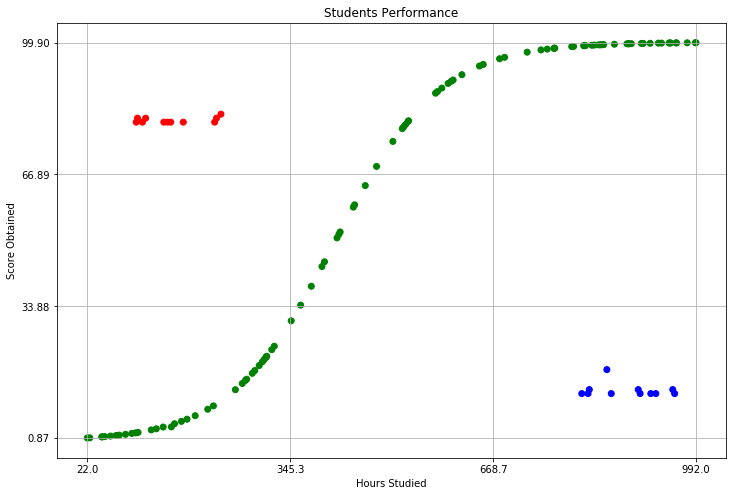

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

colors = {categories[0]:'green', categories[1]:'red', categories[2]:'blue'}

ax.scatter(students_kbins['Hours Studied'], students_kbins['Score Obtained'], 
           c=students_kbins['Comment'].apply(lambda x: colors[x]))

ax.set(xlabel='Hours Studied', ylabel='Score Obtained',
       title='Students Performance')

ax.grid()
ax.set_xticks(hours_edges);
ax.set_yticks(marks_edges);

plt.show()